In [2]:
from raphtory import Graph
from raphtory import algorithms as rp

import pandas as pd
import numpy as np
import os 
import sys
from pathlib import Path
from tqdm.notebook import tqdm
from calendar import timegm
import datetime
import time
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Load Detected Temporal Cycles
df_cycles = pd.read_parquet('../data/temporal_cycles.gzip')
df_cycles['min_ts'] = pd.to_datetime(df_cycles['min_ts'])
df_cycles['max_ts'] = pd.to_datetime(df_cycles['max_ts'])
df_cycles['duration_days'] = pd.to_timedelta(df_cycles['duration_days'])

In [ ]:
## Read NFT Transactions file
parquet_file = '../data/NFTs_Dataset/opensea_nft_transactions.parquet'
transactions = pd.read_parquet(parquet_file) 

## Read NFT Collection
nft_collections = pd.read_csv('../data/NFTs_Dataset/collection.csv')

In [ ]:
# Create 'wallets' column
df_cycles["wallets"] = df_cycles["sales"].apply(
    lambda txs: list({tx["seller"] for tx in txs} | {tx["buyer"] for tx in txs})
)

unique_wallets = set().union(*df_cycles['wallets'])
count_unique_wallets = len(unique_wallets)

print(f"Number of wallets involved in circular trading : {count_unique_wallets}")

Number of wallets involved in circular trading : 98384


In [2]:
plt.rcParams['font.size'] = '16'
sns.set(style="whitegrid")  # Optional, for a nicer style

In [3]:
# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

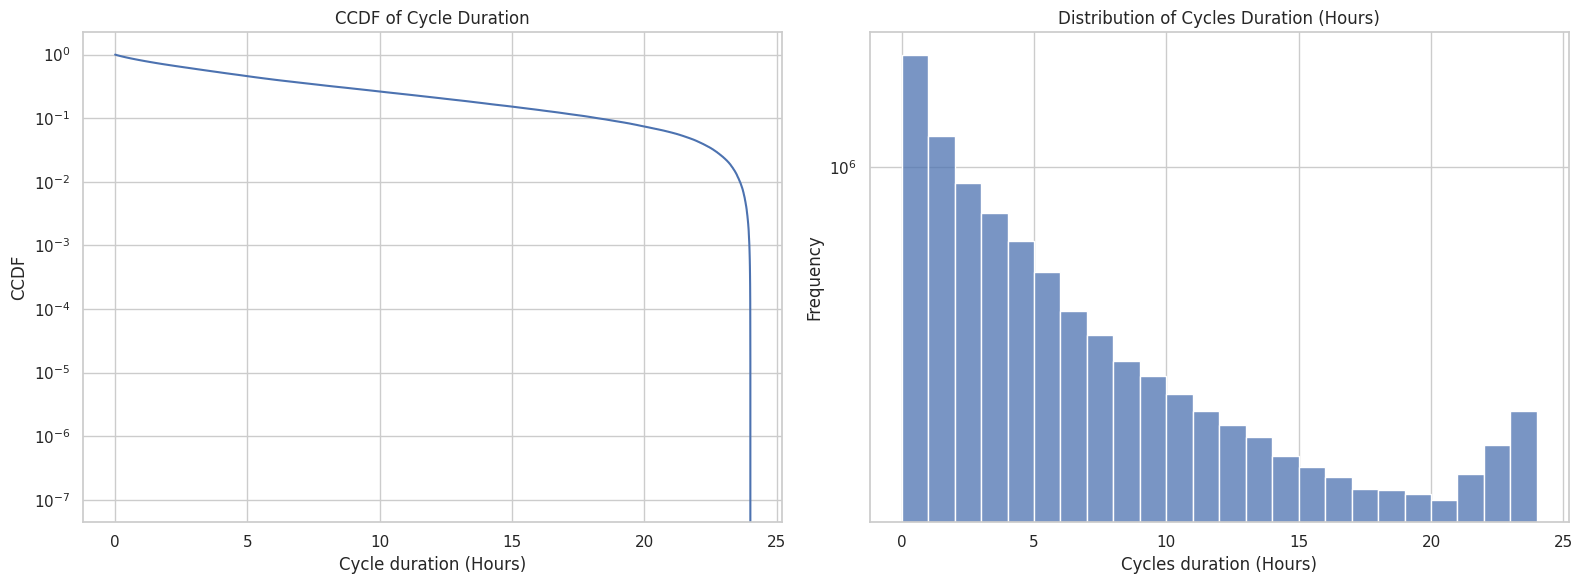

In [ ]:
from utils import ccdf

# Convert duration to hours
duration_days_numeric = [td.total_seconds() / 3600 for td in df_cycles.duration_days]

# Compute CCDF
x, y = ccdf(duration_days_numeric)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Left plot: CCDF ----
axes[0].set_yscale("log")
axes[0].plot(x, y)
axes[0].set_xlabel("Cycle duration (Hours)")
axes[0].set_ylabel("CCDF")
axes[0].set_title("CCDF of Cycle Duration")

# ---- Right plot: Histogram ----
sns.histplot(
    duration_days_numeric,
    bins=24,
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_xlabel("Cycles duration (Hours)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Cycles Duration (Hours)")

plt.tight_layout()
plt.show()


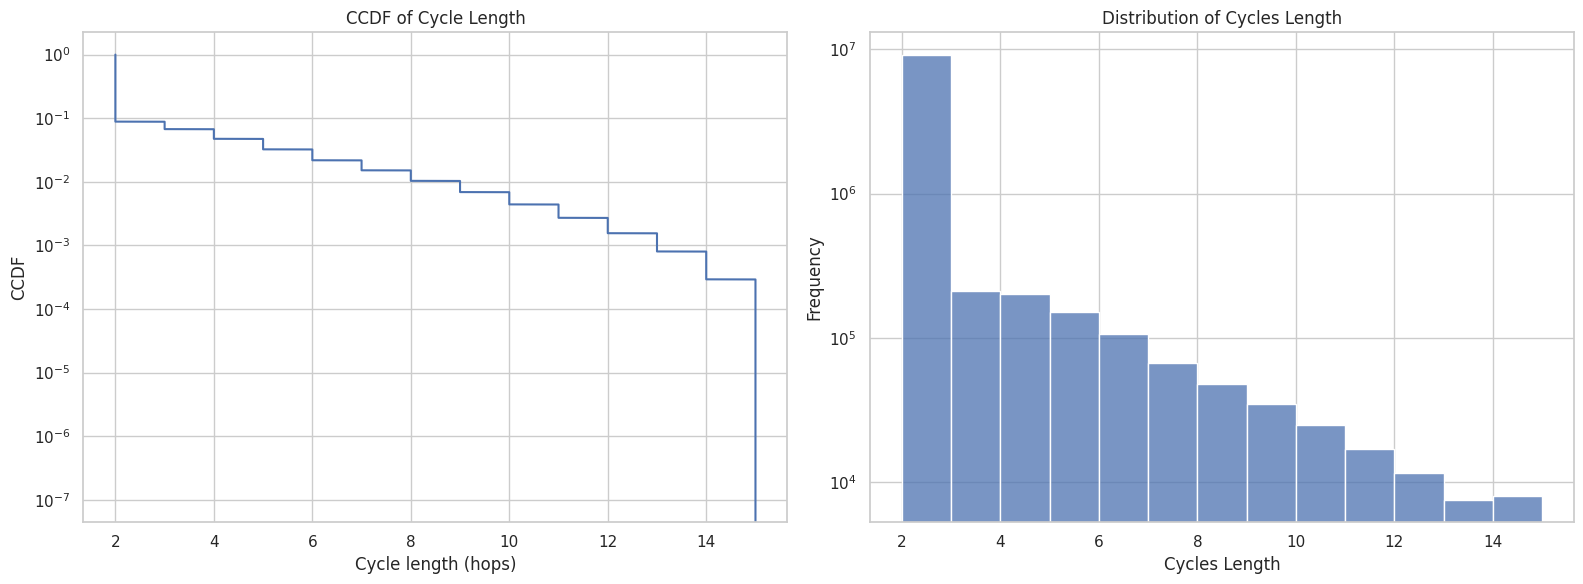

In [ ]:
# Compute CCDF
x, y = ccdf(df_cycles.cycle_length)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Left: CCDF ----
axes[0].set_yscale("log")
axes[0].plot(x, y)
axes[0].set_xlabel("Cycle length (hops)")
axes[0].set_ylabel("CCDF")
axes[0].set_title("CCDF of Cycle Length")

# ---- Right: Histogram ----
sns.histplot(
    df_cycles["cycle_length"],
    binwidth=1,
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_xlabel("Cycles Length")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Cycles Length")

plt.tight_layout()
plt.show()

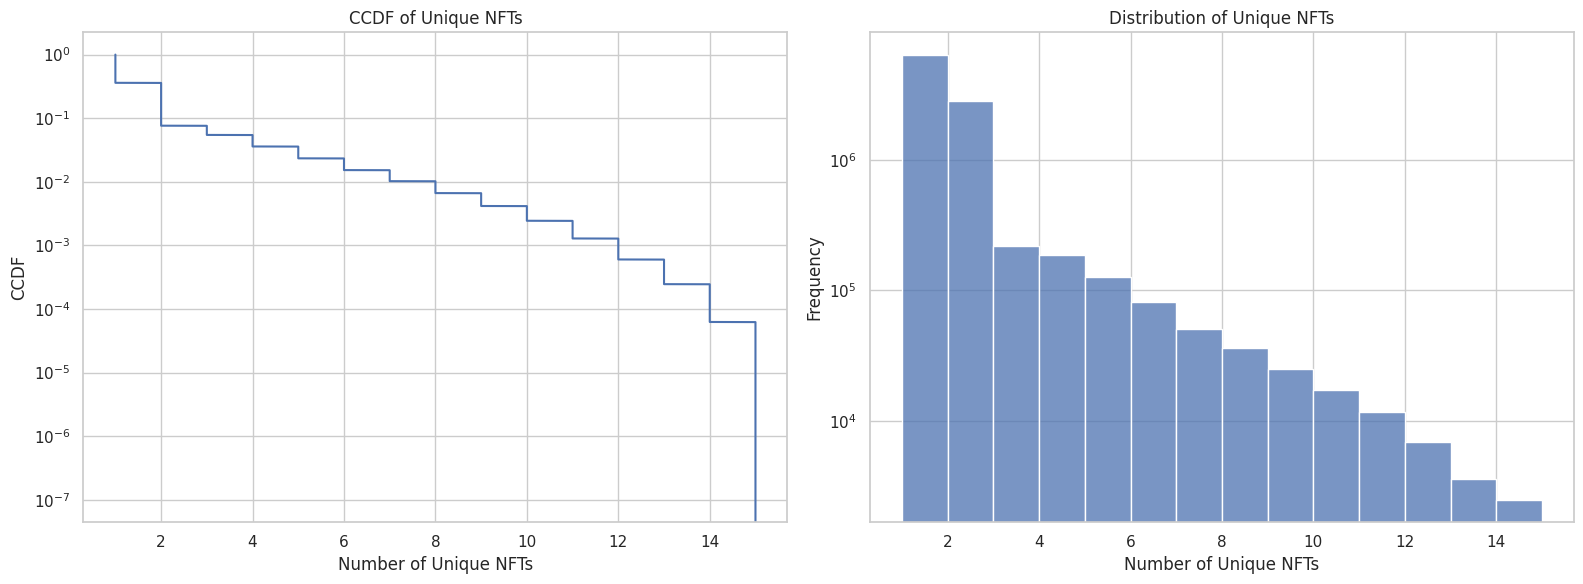

In [ ]:
# Number of unique NFT assets in each temporal cycle

# Compute CCDF
df_cycles['unique_nft_count'] = df_cycles['sales'].apply(lambda tx_list: len({tx['nft_id'] for tx in tx_list}))
x, y = ccdf(df_cycles.unique_nft_count)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Left: CCDF ----
axes[0].set_yscale("log")
axes[0].set_xscale("linear")
axes[0].plot(x, y)
axes[0].set_xlabel("Number of Unique NFTs")
axes[0].set_ylabel("CCDF")
axes[0].set_title("CCDF of Unique NFTs")

# ---- Right: Histogram ----
sns.histplot(
    df_cycles["unique_nft_count"],
    binwidth=1,
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_xlabel("Number of Unique NFTs")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Unique NFTs")

plt.tight_layout()
plt.show()

In [ ]:
## Number of temporal cycles per wallet
df_cycles_buyer = df_cycles[['buyer']].copy()
df_cycles_buyer = df_cycles_buyer['buyer'].value_counts().reset_index()
df_cycles_buyer.columns = ['buyer', 'num_cycles']
df_cycles_buyer = df_cycles_buyer.sort_values(by='num_cycles', ascending=False)



## Number of transactions per wallet
# Count transactions as buyer
buyer_counts = transactions["buyer_num"].value_counts()
# Count transactions as seller
seller_counts = transactions["seller_num"].value_counts()
# Combine both
wallet_transactions = (buyer_counts.add(seller_counts, fill_value=0)
                                      .astype(int)
                                      .reset_index())
wallet_transactions.columns = ["wallet", "num_transactions"]


## Merge both of them 
wallet_transactions_cycles = wallet_transactions.merge(df_cycles_buyer,left_on='wallet',right_on='buyer',how='left')
wallet_transactions_cycles = wallet_transactions_cycles[['wallet','num_transactions','num_cycles']]
wallet_transactions_cycles.fillna(value=0,inplace=True)

In [ ]:
#### Calculate the balance of each of the suspicious wallets 

# Start with seller earnings
seller_balance = transactions.groupby("seller_num")["price_usd"].sum()
# Buyer spends (negative balance)
buyer_balance = transactions.groupby("buyer_num")["price_usd"].sum() * -1
# Combine both
balance = seller_balance.add(buyer_balance, fill_value=0)

# Convert to DataFrame
df_balance = balance.reset_index()
df_balance.columns = ["wallet", "balance"]


## Temporal Cycles vs Transactions vs Balance 

Temporal cycle counts for nodes in the NFT graph
with δ = 24 hours and L = 15. The plot shows the
total number of temporal cycles versus the total number
of transactions (incoming and outgoing). Nodes are colored
according to wallet balance (total incoming minus total
outgoing transaction value). All axes and the color scale are
logarithmic.

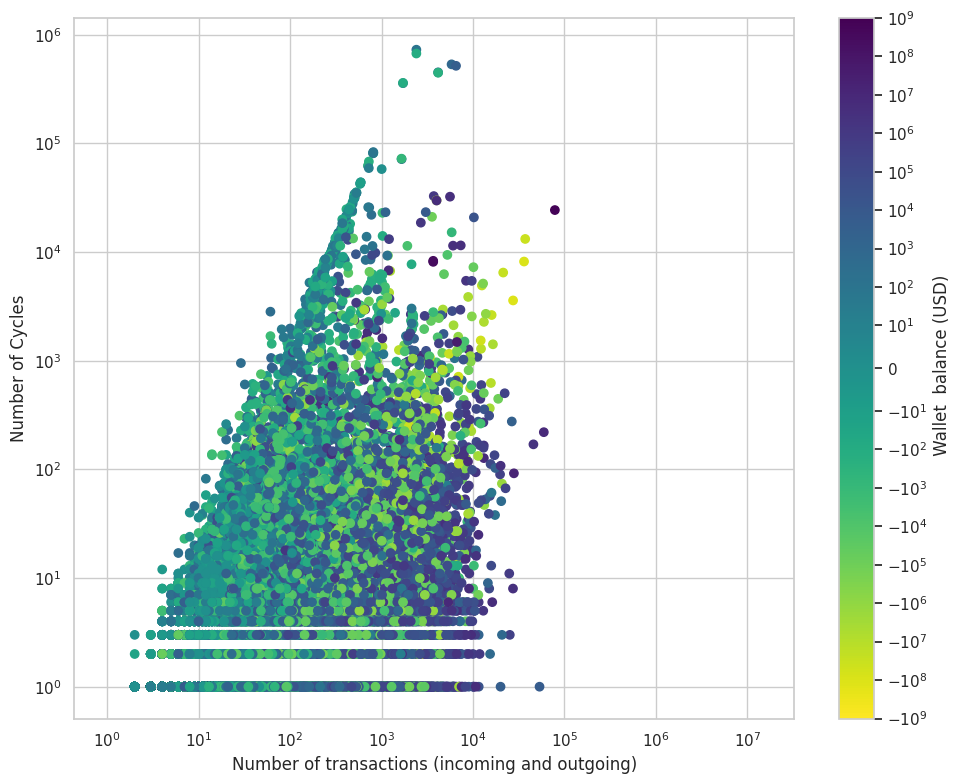

In [ ]:
from matplotlib.colors import SymLogNorm

np.random.seed(42)
wallet_transactions_cycles = wallet_transactions_cycles.merge(df_balance,on="wallet",how='left')



wallets_transactions = wallet_transactions_cycles['num_transactions']  # x-axis
motifs = wallet_transactions_cycles['num_cycles']     # y-axis
wallet_balance = wallet_transactions_cycles['balance']  # color scale

# Plot
plt.figure(figsize=(10,8))

sc = plt.scatter(
    wallets_transactions,
    motifs,
    c=wallet_balance,
    cmap="viridis_r",  # red-white-blue
    norm=SymLogNorm(linthresh=10,vmin=-1e+9, vmax=1e+9)  # symmetric log scale
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of transactions (incoming and outgoing)")
plt.ylabel("Number of Cycles")

cbar = plt.colorbar(sc)
cbar.set_label(" Wallet  balance (USD)")

plt.tight_layout()
plt.show()


## wallets ordered by number of cycles

In [ ]:
df_cycles_wallet = df_cycles[['buyer']].copy()
df_cycles_wallet = df_cycles_wallet['buyer'].value_counts().reset_index()
df_cycles_wallet.columns = ['buyer', 'num_cycles']
df_cycles_wallet = df_cycles_wallet.sort_values(by='num_cycles', ascending=False)

print(df_cycles_wallet)

           buyer  num_cycles
0      w_2824489      728518
1      w_2824495      671965
2      w_3109252      534188
3      w_3109399      517769
4      w_3388661      450876
...          ...         ...
50957    w_81584           1
50958   w_306066           1
50959   w_306063           1
50960  w_1552054           1
50961   w_409134           1

[50962 rows x 2 columns]


## Temporal Cycle–Based Detection of Automated Trading

We detect suspicious wallets by analyzing temporal cycles of NFT transactions and their inter-trade timing patterns. 
Wallets are flagged when their temporal behavior exhibits characteristics that are unlikely to arise from human-driven trading.

**Detection Criteria**

- **Rapid Transactions:**  
  Wallets participating in cycles with a mean inter-transaction time (ITT) below 60 seconds are flagged, as executing consecutive NFT trades within such a short interval strongly suggests automated trading.

- **Low Temporal Variation:**  
  Cycles with a coefficient of variation (CV) below 0.1 indicate highly regular inter-trade timing, a pattern consistent with coordinated or algorithmic execution rather than human behavior.

- **Consistent Cycle Duration:**  
  Wallets involved in multiple cycles with exceptionally stable cycle durations are flagged, as repeated and consistent execution patterns are indicative of automated trading schedules.


/tmp/ipykernel_2262460/930225046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['duration_hours'] = filtered_df['duration_days'].dt.total_seconds() / 3600


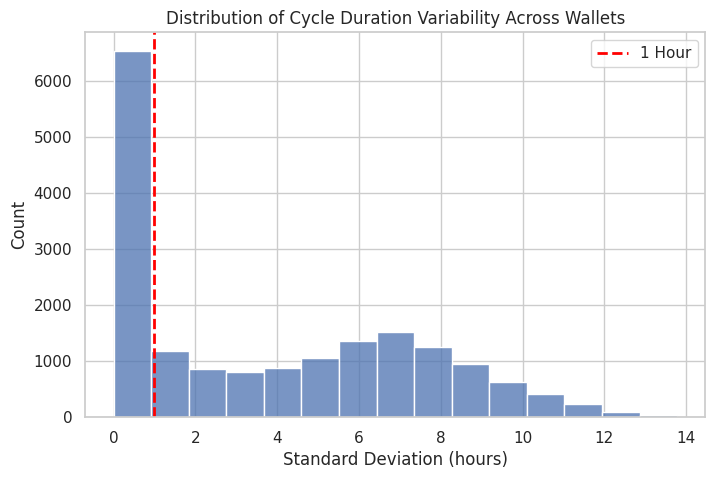

In [ ]:
filtered_df = df_cycles[df_cycles['buyer'].map(df_cycles['buyer'].value_counts()) > 2]
filtered_df['duration_hours'] = filtered_df['duration_days'].dt.total_seconds() / 3600
std_per_buyer = filtered_df.groupby('buyer')['duration_hours'].std().reset_index()
std_per_buyer.rename(columns={'duration_hours': 'std_duration_hours'}, inplace=True)
std_per_buyer.dropna(inplace=True)


# Plot histogram of standard deviations
plt.figure(figsize=(8,5))
sns.histplot(std_per_buyer['std_duration_hours'], bins=15)
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='1 Hour')
plt.xlabel('Standard Deviation (hours)')
#plt.ylabel('Count of Buyers')
plt.title('Distribution of Cycle Duration Variability Across Wallets')
plt.legend()
plt.show()

## $σ_D(w) \leq 1$ hour
Analysis of the distribution of cycle duration
variability reveals a substantial number of wallets that repeatedly participate in cycles with low temporal variation
  ( less than one hour). Motivated by this observation, we
set a 1-hour threshold to identify wallets engaged in trading cycles of unusually consistent duration. This threshold
serves as a key criterion in our automated detection framework. Wallets exhibiting low variability in cycle duration
($σ_D(w)<1$ hour) are considered potentially suspicious, as
such regularity is atypical among conventional NFT traders.

In [5]:
from utils import automated_trading_detection
suspicious_wallets  = automated_trading_detection(df_cycles=df_cycles)

Calculating time patterns: 100%|██████████| 10011269/10011269 [00:27<00:00, 369696.06it/s]
/home/wassim/NFT-Suspicious-Activity/src/utils/automated_trading_filters.py:157: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buyer_stats = df.groupby("buyer").apply(_buyer_patterns)


In [ ]:
flagged_wallets = (
    suspicious_wallets
    .assign(
        **{
            "Consistent Duration": suspicious_wallets["consistent_duration"].astype(bool),
            "Low Time Variation": suspicious_wallets["low_time_variation"] > 0.9,
            "Rapid Transactions": suspicious_wallets["rapid_transactions"] > 0,
        }
    )
    [["Consistent Duration", "Low Time Variation", "Rapid Transactions"]]
)


/home/wassim/wassim-env/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/wassim/wassim-env/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

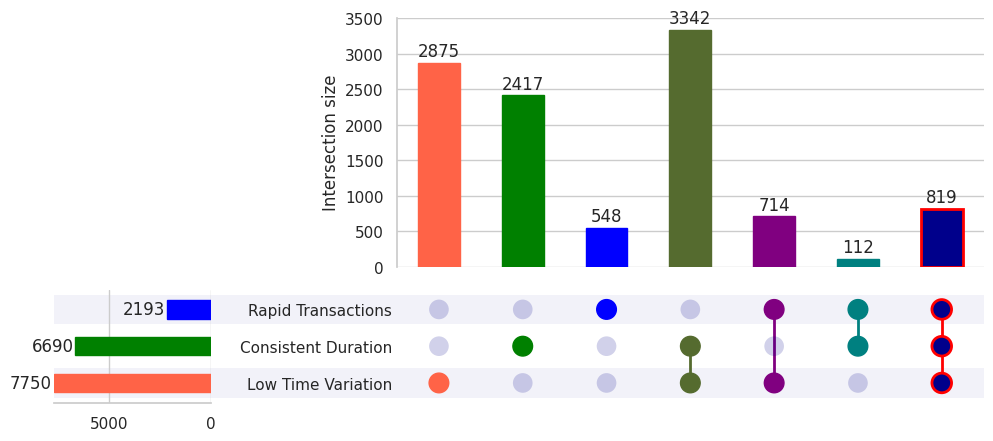

In [ ]:
from upsetplot import UpSet
from upsetplot import UpSet, from_indicators

# Create your figure with the size you want
fig = plt.figure(figsize=(12, 5))  # wider or taller depending on your needs

# df has columns: col1, col2, col3 — all bools
example = from_indicators(flagged_wallets.columns, flagged_wallets)

# Create upset object, set element_size=None so upsetplot doesn’t override your figure size
upset = UpSet(example, element_size=None,show_counts=True,facecolor="darkblue",include_empty_subsets=False)

# Style the horizontal bars (totals) per category
# Important: style_categories only changes *all* selected categories to the same style,
# so you cannot specify a different color for each with a single call. 
# But you *can* call it multiple times for different categories.

upset.style_categories(
    ['Low Time Variation'], 
    bar_facecolor="tomato", 
    bar_edgecolor=None
)
upset.style_categories(
    ['Consistent Duration'], 
    bar_facecolor="green", 
    bar_edgecolor=None
)
upset.style_categories(
    ['Rapid Transactions'], 
    bar_facecolor="blue", 
    bar_edgecolor=None
)



# Style intersection bars
upset.style_subsets(present=['Low Time Variation'], max_degree=1, facecolor="tomato")
upset.style_subsets(present=['Consistent Duration'], max_degree=1, facecolor="green")
upset.style_subsets(present=['Rapid Transactions'], max_degree=1, facecolor="blue")
upset.style_subsets(present=['Consistent Duration','Low Time Variation'], max_degree=2, facecolor="darkolivegreen",)
upset.style_subsets(present=['Low Time Variation','Rapid Transactions'], max_degree=2, facecolor="purple")
upset.style_subsets(present=['Consistent Duration','Rapid Transactions'], max_degree=2, facecolor="teal")
upset.style_subsets(present=['Consistent Duration','Rapid Transactions'], min_degree=3, edgecolor="red",linewidth=2)

upset.plot(fig=fig)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
"""
from utils import wallets_trading_details , filter_automated_wallets
suspicious_wallets['buyer']=suspicious_wallets.index
suspicious_wallets.reset_index(drop=True, inplace=True)
suspicious_wallets = wallets_trading_details(suspicious_buyers=suspicious_wallets,transactions_table=transactions)
suspicious_automated_wallets = filter_automated_wallets(suspicious_wallets)

"""

In [ ]:
suspicious_automated_wallets = pd.read_csv('../flagged/automated_trading_highly_suspicious.csv')
suspicious_automated_wallets.head()

,cycle_count,consistent_duration,low_time_variation,rapid_transactions,wallet,num_bought,num_sold,unique_nfts_bought,unique_nfts_sold,hold_time,first_activity,last_activity,activity_period,average_daily_transaction
0,72373,False,1.0,0.014909,w_103861,849,804.0,87,87.0,0 days 03:30:51.857142857,2023-06-08 13:20:07,2023-12-05 14:28:45,180 days 01:08:38,9.132597
1,71651,False,1.0,0.013761,w_103860,792,865.0,84,171.0,0 days 08:02:38.193724420,2023-07-20 12:33:04,2023-12-05 14:28:45,138 days 01:55:41,11.920863
2,62633,False,1.0,0.003257,w_2565146,380,333.0,1,1.0,0 days 01:54:52.408408408,2022-05-19 05:52:17,2022-05-20 08:10:05,1 days 02:17:48,356.500000
3,58029,False,1.0,0.005532,w_2403871,508,496.0,2,2.0,0 days 01:17:35.708609271,2022-06-15 22:36:11,2022-06-17 05:14:20,1 days 06:38:09,502.000000
4,34180,False,1.0,0.004886,w_2403869,246,260.0,1,1.0,0 days 00:01:34.666666666,2022-06-16 07:44:03,2022-06-17 05:14:20,0 days 21:30:17,506.000000


In [ ]:
suspicious_automated_wallets["number_tx"] = suspicious_automated_wallets['num_bought'] + suspicious_automated_wallets['num_sold']
suspicious_automated_wallets["hold_time"] = pd.to_timedelta(suspicious_automated_wallets["hold_time"])
suspicious_automated_wallets["hold_minutes"] = suspicious_automated_wallets["hold_time"].dt.total_seconds() / 60
suspicious_automated_wallets["hold_hours"] = suspicious_automated_wallets["hold_time"].dt.total_seconds() / 3600

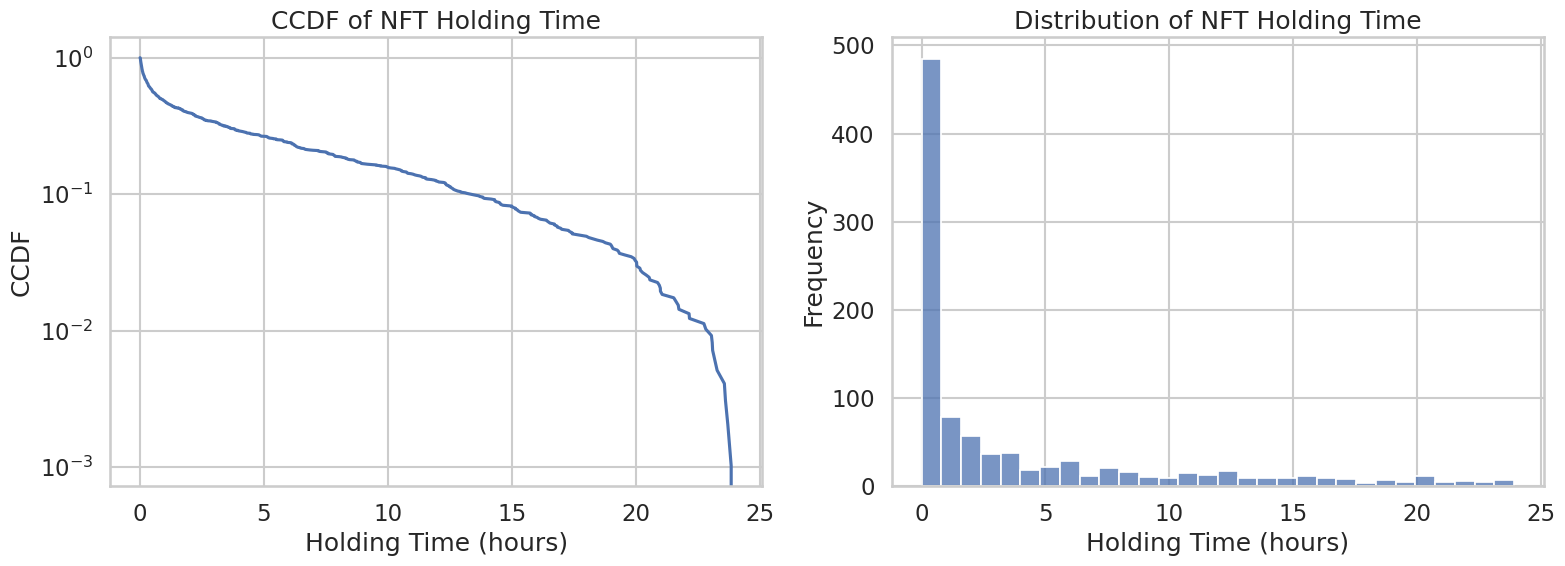

In [ ]:
# CCDF of holding time (hours)
x, y = ccdf(suspicious_automated_wallets["hold_hours"])
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- Left: CCDF ----
axes[0].set_yscale("log")
axes[0].set_xscale("linear")
axes[0].plot(x, y)
axes[0].set_xlabel("Holding Time (hours)")
axes[0].set_ylabel("CCDF")
axes[0].set_title("CCDF of NFT Holding Time")

# ---- Right: Histogram ----
sns.histplot(
    suspicious_automated_wallets["hold_hours"],
    bins=30,          # adjust if needed
    ax=axes[1]
)
#axes[1].set_yscale("log")
axes[1].set_xlabel("Holding Time (hours)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of NFT Holding Time")

plt.tight_layout()
plt.show()


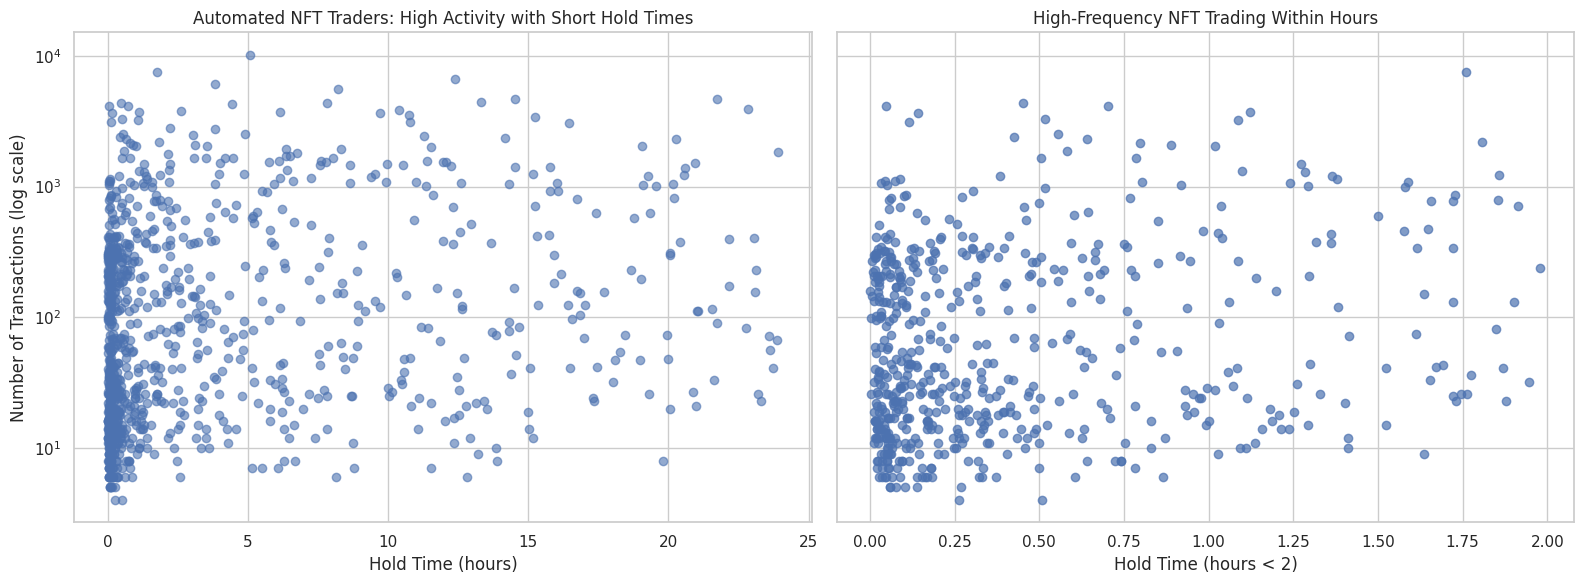

In [ ]:
short_hold = suspicious_automated_wallets[
    suspicious_automated_wallets["hold_hours"] < 2
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Plot 1: All automated wallets ---
axes[0].scatter(
    suspicious_automated_wallets["hold_hours"],
    suspicious_automated_wallets["number_tx"],
    alpha=0.6
)
axes[0].set_yscale("log")
axes[0].set_xlabel("Hold Time (hours)")
axes[0].set_ylabel("Number of Transactions (log scale)")
axes[0].set_title("Automated NFT Traders: High Activity with Short Hold Times")
axes[0].grid(True)

# --- Plot 2: Zoom on short hold time ---

axes[1].scatter(
    short_hold["hold_hours"],
    short_hold["number_tx"],
    alpha=0.7
)
axes[1].set_yscale("log")
axes[1].set_xlabel("Hold Time (hours < 2)")
axes[1].set_title("High-Frequency NFT Trading Within Hours")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
suspicious_wallet_set = set(suspicious_automated_wallets["wallet"]) 

suspicious_transactions = df_cycles[
    df_cycles["buyer"].isin(suspicious_wallet_set) 
]
df_suspicious_transactions = suspicious_transactions["sales"].explode().apply(pd.Series).reset_index(drop=True).drop_duplicates()

In [ ]:
print(f'Number of Suspicious Wallets : {len(suspicious_automated_wallets)}')
print(f'Number of Transactions : {len(df_suspicious_transactions)}')
print(f'Trading Volume : {df_suspicious_transactions['price_usd'].sum().item()* 1e-9:.3f} M')

Number of Suspicious Wallets : 978
Number of Transactions : 45345
Trading Volume : 3.6882938579740636 M


In [ ]:
# Suspicious NFTs 
nft_suspicious = df_suspicious_transactions["nft_id"].value_counts().reset_index()
nft_suspicious.columns = ["nft_id", "count"]


# For each NFT, count unique wallets (buyer or seller)
nft_stats = (
    df_suspicious_transactions
    .groupby("nft_id")
    .agg(unique_wallets=("buyer", lambda x: set(x)))
    .reset_index()
)

# Add sellers into the set of wallets
nft_stats["unique_wallets"] = nft_stats.apply(
    lambda row: set(df_suspicious_transactions[df_suspicious_transactions["nft_id"] == row["nft_id"]]["buyer"])
                .union(set(df_suspicious_transactions[df_suspicious_transactions["nft_id"] == row["nft_id"]]["seller"])),
    axis=1
)

# Also add a column with the count of unique wallets
nft_stats["num_unique_wallets"] = nft_stats["unique_wallets"].apply(len)
nft_suspicious = nft_suspicious.merge(nft_stats,on='nft_id',how='inner')


nft_suspicious.head()


            nft_id                   unique_wallets  num_unique_wallets
0     nft_10000388                       {w_120519}                   1
1      nft_1000764               {w_170256, w_5597}                   2
2     nft_10026329             {w_120519, w_145023}                   2
3     nft_10027385           {w_1320520, w_1279104}                   2
4     nft_10027654             {w_946501, w_186067}                   2
...            ...                              ...                 ...
6427    nft_996294              {w_222510, w_77016}                   2
6428   nft_9968665  {w_455278, w_536367, w_1722973}                   3
6429   nft_9987151            {w_1320520, w_203221}                   2
6430   nft_9996509             {w_672483, w_836441}                   2
6431   nft_9998639                       {w_120519}                   1

[6432 rows x 3 columns]


In [ ]:
## NFT collections 
nft_suspicious = nft_suspicious.merge(nft_collections,on='nft_id',how='left')
nft_suspicious.drop(columns=['nft_num'],inplace=True)
nft_suspicious = nft_suspicious[nft_suspicious['count']>2]
nft_suspicious = nft_suspicious[nft_suspicious['num_unique_wallets']<nft_suspicious['count']]


# Select the NFT collection involved in NFT automated trading 
# Suspicious NFTs  Collections 
nft_collections_suspicious = nft_suspicious["collection_name"].value_counts().reset_index()
nft_collections_suspicious.columns = ["collection_name", "count"]
print(f'Number of NFT assets : {len(nft_suspicious)} ')
print(f'Number of NFT collections : {len(nft_collections_suspicious)} ')

/tmp/ipykernel_2271993/1044920916.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


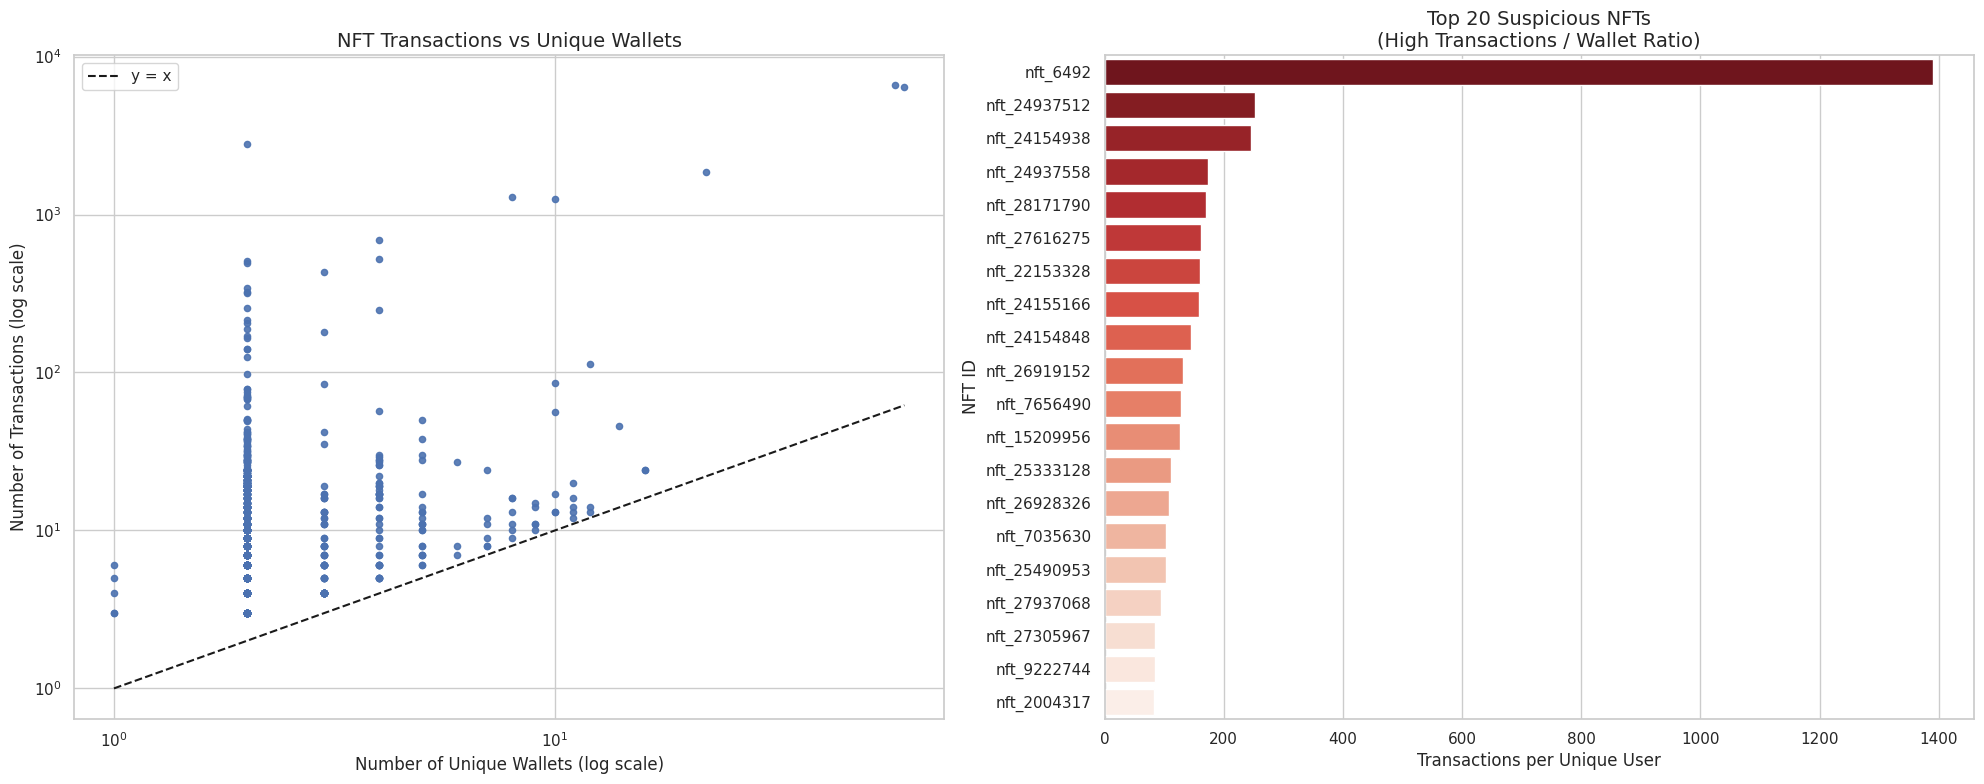

In [ ]:
# Compute ratio
nft_suspicious["tx_user_ratio"] = (
    nft_suspicious["count"] / nft_suspicious["num_unique_wallets"]
)

# Sort NFTs by ratio
top_suspicious = (
    nft_suspicious.sort_values("tx_user_ratio", ascending=False)
    .head(20)
)

# Create 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# -------- Plot 1: Scatter plot --------
axes[0].scatter(
    nft_suspicious["num_unique_wallets"],
    nft_suspicious["count"],
    s=20,
    alpha=0.9
)

# Log scales
axes[0].set_xscale("log")
axes[0].set_yscale("log")

# Diagonal reference line (y = x)
x = np.linspace(
    nft_suspicious["num_unique_wallets"].min(),
    nft_suspicious["num_unique_wallets"].max(),
    100
)
axes[0].plot(x, x, "k--", label="y = x")

axes[0].set_title("NFT Transactions vs Unique Wallets", fontsize=14)
axes[0].set_xlabel("Number of Unique Wallets (log scale)")
axes[0].set_ylabel("Number of Transactions (log scale)")
axes[0].legend()

# -------- Plot 2: Bar plot --------
sns.barplot(
    data=top_suspicious,
    x="tx_user_ratio",
    y="nft_id",
    palette="Reds_r",
    ax=axes[1]
)

axes[1].set_title(
    "Top 20 Suspicious NFTs\n(High Transactions / Wallet Ratio)",
    fontsize=14
)
axes[1].set_xlabel("Transactions per Unique User")
axes[1].set_ylabel("NFT ID")

plt.tight_layout()
plt.show()


/tmp/ipykernel_2271993/247643325.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nft_collections_suspicious[:20], y='collection_name', x='count', palette='viridis')


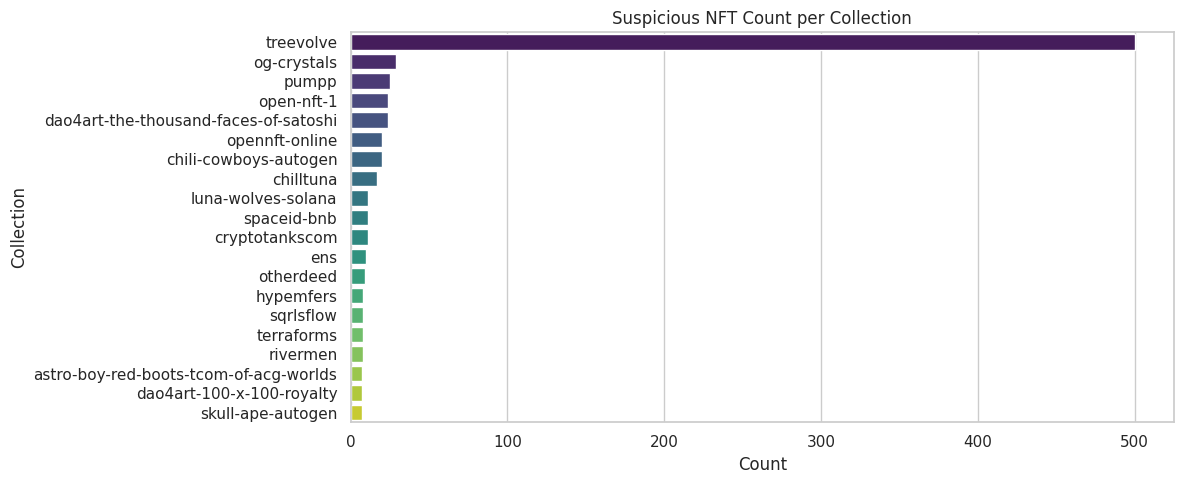

In [ ]:
# Example dataframe: df has columns 'collection_name' and 'count'
plt.figure(figsize=(12,5))
nft_collections_suspicious.sort_values(by='count',ascending=False,inplace=True)
sns.barplot(data=nft_collections_suspicious[:20], y='collection_name', x='count', palette='viridis')

plt.xticks(rotation=0)  # rotate x labels for readability
plt.ylabel("Collection")
plt.xlabel("Count")
#plt.xscale('log')
plt.title("Suspicious NFT Count per Collection")
plt.tight_layout()
plt.show()


## Temporal Cycle–Based Detection of Wash Trading

Wash trading is a manipulative practice in which the same entity repeatedly buys and sells NFTs to fabricate market activity.
We detect wash trading by analyzing temporal cycles that capture recurrent, coordinated trading patterns unlikely to occur in legitimate markets.

**Detection Criteria**

- **Round-Trip Trading:**  
  Temporal cycles involving only a single NFT are flagged, as selling and repurchasing the same asset within a short time window strongly indicates artificial volume generation without genuine ownership transfer.

- **Price Stability:**  
  Cycles with unusually stable transaction prices are flagged, as coordinated traders typically exchange NFTs at nearly identical prices. 
  We classify a cycle as suspicious when the price coefficient of variation remains below 5%, indicating non-market-driven price behavior.

- **Recurrent Collusive Trading:**  
  Cycles involving highly overlapping sets of wallets across multiple occurrences are flagged, as repeated circular trading among the same participants suggests coordinated control. 
  We identify such behavior using the Repeat Cycle Index (RCI), which captures recurring wallet group participation across temporal cycles.


In [11]:
from utils import wash_trading_detection , wallets_single_collection_activity , filter_wash_traders

In [ ]:
circular, stable_price, cross_nft = wash_trading_detection(df_cycles,max_workers=64)

Processing collections (parallel, exact Jaccard): 100%|██████████| 2886/2886 [2:16:29<00:00,  2.84s/it]  


In [ ]:
# ------------------------------------------------------------------
# 1. Assign pattern type in a consistent, declarative way
# ------------------------------------------------------------------
patterns = {
    "Recurrent Collusive Trading": cross_nft,
    "Price Stability": stable_price,
    "Round Trip Trading": circular,
}

wash_trades = (
    pd.concat(
        [df.assign(type=label) for label, df in patterns.items()],
        ignore_index=True
    )
    .drop(
        columns=[
            "nft_id",
            "price_stability",
            "avg_jaccard_similarity",
            "cross_nft_repetition",
            "wallet_set",
        ],
        errors="ignore"  # safer for notebooks
    )
)

# ------------------------------------------------------------------
# 2. One-hot encode type directly (no intermediate df needed)
# ------------------------------------------------------------------
key_cols = [
    "cycle_length",
    "profit",
    "buyer",
    "collection_name",
    "min_ts",
    "max_ts",
]

df_final = (
    wash_trades
    .assign(flag=True)
    .pivot_table(
        index=key_cols,
        columns="type",
        values="flag",
        aggfunc="max",
        fill_value=False,
    )
    .reset_index()
)

# ------------------------------------------------------------------
# 3. Keep only semantic columns (already correctly named)
# ------------------------------------------------------------------
df_final = df_final[
    [
        "Recurrent Collusive Trading",
        "Round Trip Trading",
        "Price Stability",
    ]
]


In [ ]:
suspicious_cycles = wash_trades.drop_duplicates(subset=['cycle_length','profit','buyer','collection_name','min_ts','max_ts'],inplace=False).copy()
print(f'Number of Suspicious Wash Trading Cycles : {len(suspicious_cycles)}')

Number of Suspicious Wash Trading Cycles : 1204669


/home/wassim/wassim-env/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/wassim/wassim-env/lib/python3.13/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

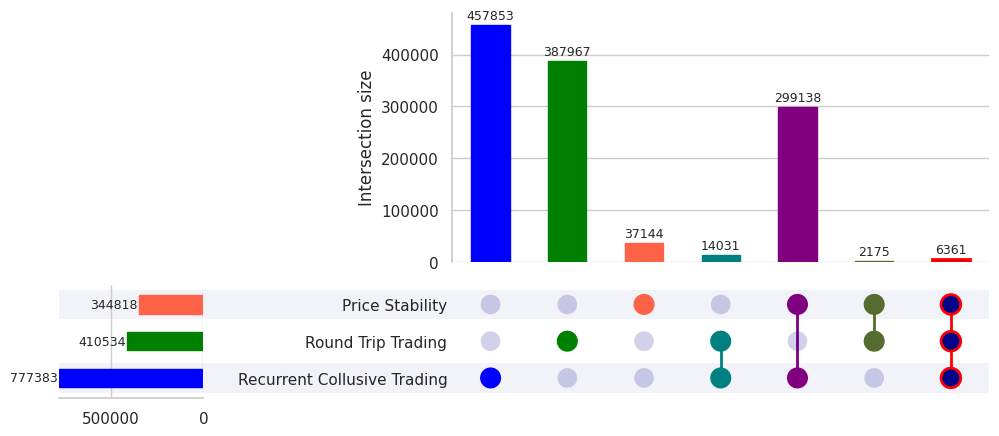

In [ ]:
from upsetplot import UpSet, from_indicators

import seaborn as sns
sns.set(style="whitegrid")
matplotlib.rcParams["font.size"] = 9

# Create your figure with the size you want
fig = plt.figure(figsize=(12, 5))  # wider or taller depending on your needs

# df has columns: col1, col2, col3 — all bools
example = from_indicators(df_final.columns, df_final)

# Create upset object, set element_size=None so upsetplot doesn’t override your figure size
upset = UpSet(example, element_size=None,show_counts=True,facecolor="darkblue",include_empty_subsets=False)

# Style the horizontal bars (totals) per category
# Important: style_categories only changes *all* selected categories to the same style,
# so you cannot specify a different color for each with a single call. 
# But you *can* call it multiple times for different categories.

upset.style_categories(
    ['Price Stability'], 
    bar_facecolor="tomato", 
    bar_edgecolor=None
)
upset.style_categories(
    ['Round Trip Trading'], 
    bar_facecolor="green", 
    bar_edgecolor=None
)
upset.style_categories(
    ['Recurrent Collusive Trading'], 
    bar_facecolor="blue", 
    bar_edgecolor=None
)



# Style intersection bars
upset.style_subsets(present=['Price Stability'], max_degree=1, facecolor="tomato")
upset.style_subsets(present=['Round Trip Trading'], max_degree=1, facecolor="green")
upset.style_subsets(present=['Recurrent Collusive Trading'], max_degree=1, facecolor="blue")

upset.style_subsets(present=['Price Stability','Recurrent Collusive Trading'], max_degree=2, facecolor="purple") 
upset.style_subsets(present=['Round Trip Trading','Recurrent Collusive Trading'], max_degree=2, facecolor="teal")
upset.style_subsets(present=['Price Stability','Round Trip Trading'], max_degree=2, facecolor="darkolivegreen")

upset.style_subsets(present=['Round Trip Trading','Recurrent Collusive Trading'], min_degree=3, edgecolor="red",linewidth=2)

upset.plot(fig=fig)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [5]:
## Read pre-detected suspicious wash trading cycles 
suspicious_cycles = pd.read_parquet('../flagged/suspicious_cycles.gzip')

Some wallets were initially flagged due to incidental interactions with wash traders rather than direct involvement.
To reduce false positives, a stricter filtering strategy was applied. Wallets were retained only if they:

- Participated in more than two temporal circular trading cycles within the same NFT collection

- Conducted over 50% of their transactions with other wallets involved in suspected wash-trading cycles.

These criteria indicate coordinated trading behavior aimed at inflating NFT trading volume of a specific NFT asset or collection. 

In [12]:
# (i) appeared in more than two temporal cycles and repeatedly engaged in circular trading involving the same NFT collection
Wash_traders_same_collection = wallets_single_collection_activity(suspicious_cycles)

# (ii) conducted more than 50% of their transactions with wallets also identified as participating in potential 
# wash trading cycles within that same NFT collection
suspicious_wash_traders = filter_wash_traders(Wash_traders_same_collection,transactions)

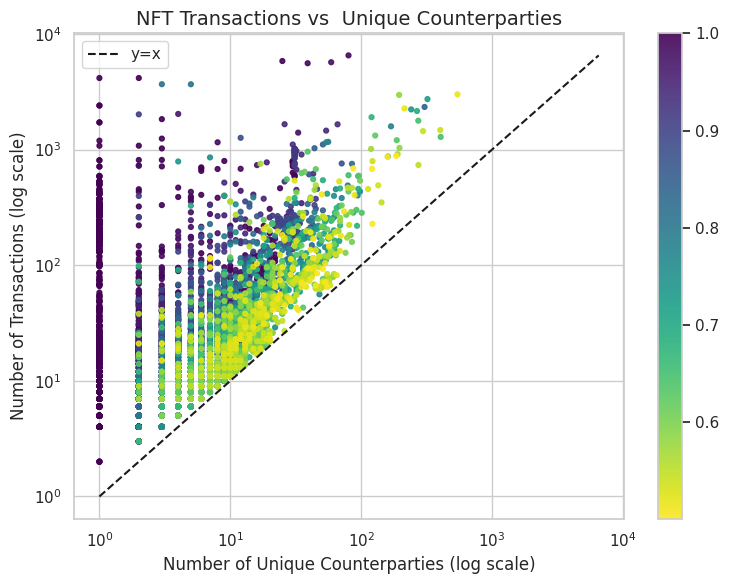

In [ ]:
# Compute ratio
sns.set(style="whitegrid")

plt.figure(figsize=(8,6))

# Create scatter plot
scatter = plt.scatter(
    suspicious_wash_traders["unique_counterparties"],
    suspicious_wash_traders["total_transactions"],
    s=12,
    alpha=0.9,
    c=suspicious_wash_traders['in_group_ratio'],
    cmap='viridis_r'
)

# Log scales to handle imbalance
plt.xscale("log")
plt.yscale("log")
# Add diagonal reference line in log-space
x = np.linspace(suspicious_wash_traders["unique_counterparties"].min(), suspicious_wash_traders["total_transactions"].max(), 100)
plt.plot(x, x, 'k--', label='y=x')


# Labels and title
plt.title("NFT Transactions vs  Unique Counterparties", fontsize=14)
plt.xlabel("Number of Unique Counterparties (log scale)")
plt.ylabel("Number of Transactions (log scale)")
plt.legend()
plt.tight_layout()
plt.colorbar()
plt.show()


In [ ]:
## Suspicious Transactions

wash_traders_wallets = set(suspicious_wash_traders['wallet'])
wash_trading_tx = transactions[
    (transactions['seller_num'].isin(wash_traders_wallets)) |
    (transactions['buyer_num'].isin(wash_traders_wallets))
].copy()

Number of flagged suspicious wash traders : 5005
Number of suspicious Wash trading transactions: 272617
Wash Trading Volume : 11.210 M


In [ ]:
# Suspicious NFTs 
wash_trading_tx["nft_id"] = wash_trading_tx["nft_num"]
nft_suspicious = wash_trading_tx["nft_id"].value_counts().reset_index()
nft_suspicious.columns = ["nft_id", "count"]
nft_suspicious = nft_suspicious[nft_suspicious['count']>2]

# gather wallets per NFT using groupby
unique_wallets_per_nft = (
    wash_trading_tx
    .groupby("nft_id")
    .apply(lambda g: set(g["seller_num"]) | set(g["buyer_num"]))
    .rename("unique_wallets")
)
nft_stats = pd.DataFrame(unique_wallets_per_nft)

# Also add a column with the count of unique wallets
nft_stats["num_unique_wallets"] = nft_stats["unique_wallets"].apply(len)

nft_suspicious = nft_suspicious.merge(nft_stats,on='nft_id',how='inner')
nft_suspicious = nft_suspicious.merge(nft_collections,on='nft_id',how='left')


/tmp/ipykernel_2320395/2364388820.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: set(g["seller_num"]) | set(g["buyer_num"]))


In [ ]:
print(f'Number of flagged suspicious wash traders : {len(suspicious_wash_traders)}')
print(f'Number of suspicious Wash trading transactions: {len(wash_trading_tx)}')
print(f'Flagged Suspicious NFT assets: {len(nft_suspicious)}')
print(f'Wash Trading Volume : {wash_trading_tx['price_usd'].sum().item()* 1e-9:.3f} M')

Number of flagged suspicious wash traders : 5005
Number of suspicious Wash trading transactions: 272617
Flagged Suspicious NFT assets: 15167
Wash Trading Volume : 11.210 M


/tmp/ipykernel_2320395/2207583350.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


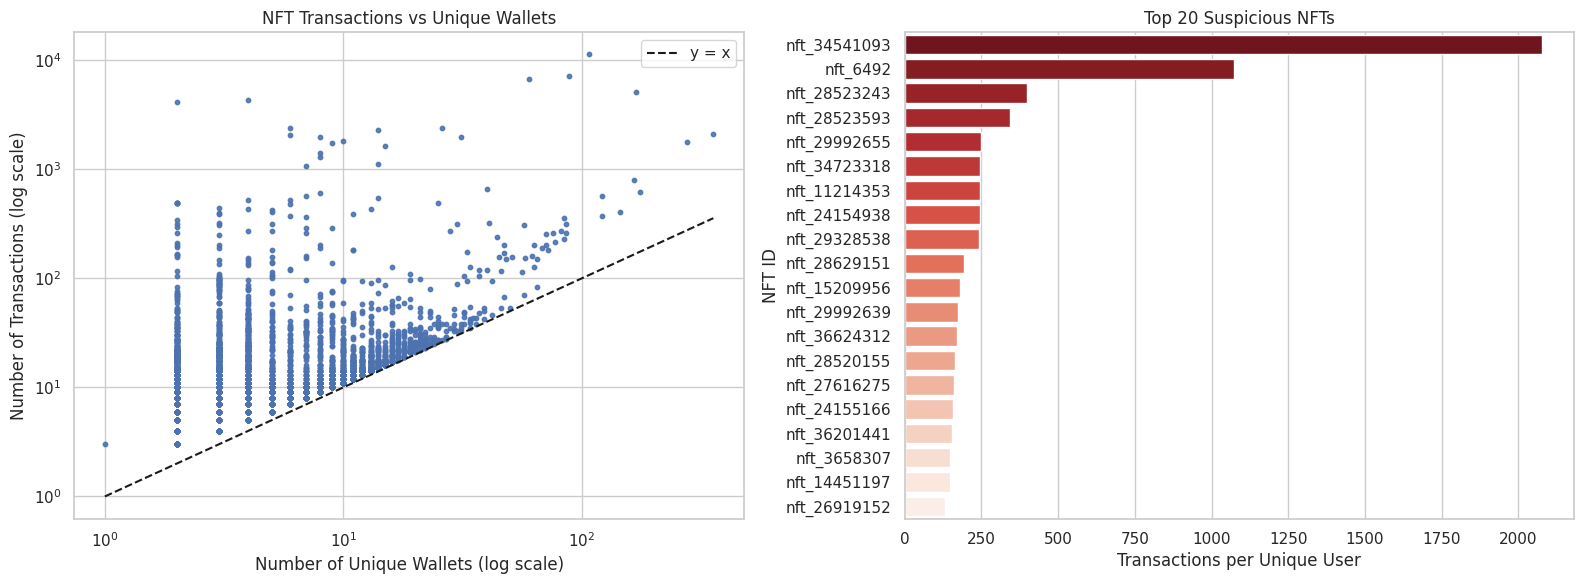

In [ ]:
# Compute ratio
nft_suspicious = nft_suspicious[
    nft_suspicious['num_unique_wallets'] < nft_suspicious['count']
].copy()

nft_suspicious["tx_user_ratio"] = (
    nft_suspicious["count"] / nft_suspicious["num_unique_wallets"]
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(
    nft_suspicious["num_unique_wallets"],
    nft_suspicious["count"],
    s=10,
    alpha=0.9
)

axes[0].set_xscale("log")
axes[0].set_yscale("log")

# Diagonal y = x
x = np.linspace(
    nft_suspicious["num_unique_wallets"].min(),
    nft_suspicious["num_unique_wallets"].max(),
    100
)
axes[0].plot(x, x, 'k--', label='y = x')

axes[0].set_title("NFT Transactions vs Unique Wallets")
axes[0].set_xlabel("Number of Unique Wallets (log scale)")
axes[0].set_ylabel("Number of Transactions (log scale)")
axes[0].legend()


top_suspicious = (
    nft_suspicious
    .sort_values("tx_user_ratio", ascending=False)
    .head(20)
)

sns.barplot(
    data=top_suspicious,
    x="tx_user_ratio",
    y="nft_id",
    palette="Reds_r",
    ax=axes[1]
)

axes[1].set_title("Top 20 Suspicious NFTs")
axes[1].set_xlabel("Transactions per Unique User")
axes[1].set_ylabel("NFT ID")

# Layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_2320395/114556011.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nft_collections_suspicious[:20], y='collection_name', x='count', palette='viridis')


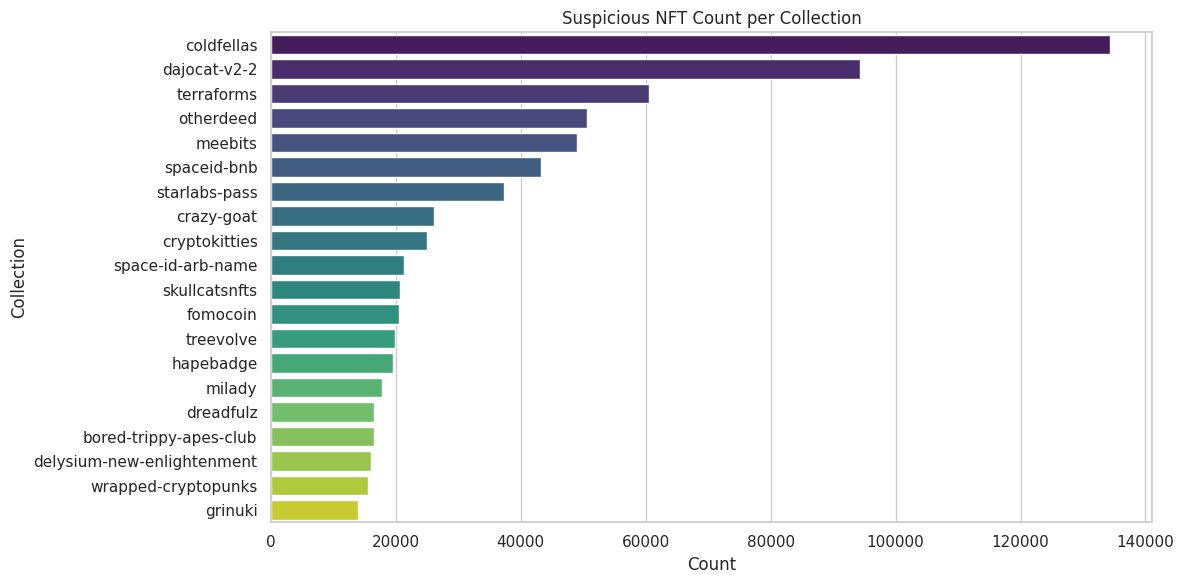

In [ ]:
# Select the NFT collection involved in NFT automated trading 
# Suspicious NFTs  Collections 
nft_collections_suspicious = suspicious_cycles["collection_name"].value_counts().reset_index()
nft_collections_suspicious.columns = ["collection_name", "count"]
nft_collections_suspicious = nft_collections_suspicious[nft_collections_suspicious['count']>2]


# Example dataframe: df has columns 'collection_name' and 'count'
plt.figure(figsize=(12,6))
sns.barplot(data=nft_collections_suspicious[:20], y='collection_name', x='count', palette='viridis')

plt.xticks(rotation=0)  # rotate x labels for readability
plt.ylabel("Collection")
plt.xlabel("Count")
#plt.xscale('log')
plt.title("Suspicious NFT Count per Collection")
plt.tight_layout()
plt.show()

### Validation Through Cross-Study Comparison

In the absence of ground-truth labels that would allow direct evaluation of
our detection results, we employ an external validation
strategy by comparing our findings with those reported
in earlier work.

In [ ]:
from utils import flag_suspicious_collections
suspicious_collections = flag_suspicious_collections(
    df_cycles,
    suspicious_cycles,
    transactions
)
print(f'Number of suspicious collections : {len(suspicious_collections)}')

Number of suspicious collections : 534


In [ ]:
# import flagged collections 

flagged_collection = pd.read_csv('../flagged/flagged_collections.csv')
flagged_collection_ = set(flagged_collection.collection)
in_dataset = []
out_dataset = []
collection_dataset = set(nft_collections.collection_name)
for collection in flagged_collection_ :
    if collection in collection_dataset :
        in_dataset.append(collection)
    else :
        out_dataset.append(collection)


## Check if there are flaged
TP = []
FP = []

for collection in in_dataset:
    if collection in suspicious_collections:
        TP.append(collection)
    else : 
        FP.append(collection)

print(f'Number of Flagged NFT collections : {len(TP)} \n')
print(f'Unflagged NFT collections : {FP}')


Number of Flagged NFT collections : 3 

Unflagged NFT collections : ['sadgirlsbar', 'autoglyphs', 'foundation']


## Temporal Motif-Based Characterization

To further analyze wallets flagged as suspicious, we extend our study using temporal motif analysis.
Temporal motifs capture small, recurring transaction patterns while preserving the order and timing of interactions.
By comparing the motif distributions of suspicious wallets to typical market behavior, we identify characteristic structural and temporal patterns that provide additional evidence of anomalous or coordinated trading activity.



### Automated Trading

In [ ]:
from utils.temporal_graph_utils import build_temporal_graph , temporal_motifs_characterization


# build NFT transactional  graph 
g = build_temporal_graph(transactions)

# Temporal Motifs Characterization
suspicious_motifs , normal_motifs , motifs = temporal_motifs_characterization(g,suspicious_wallet=set(suspicious_wallets.index),delta=60) # delta = 60 seconds

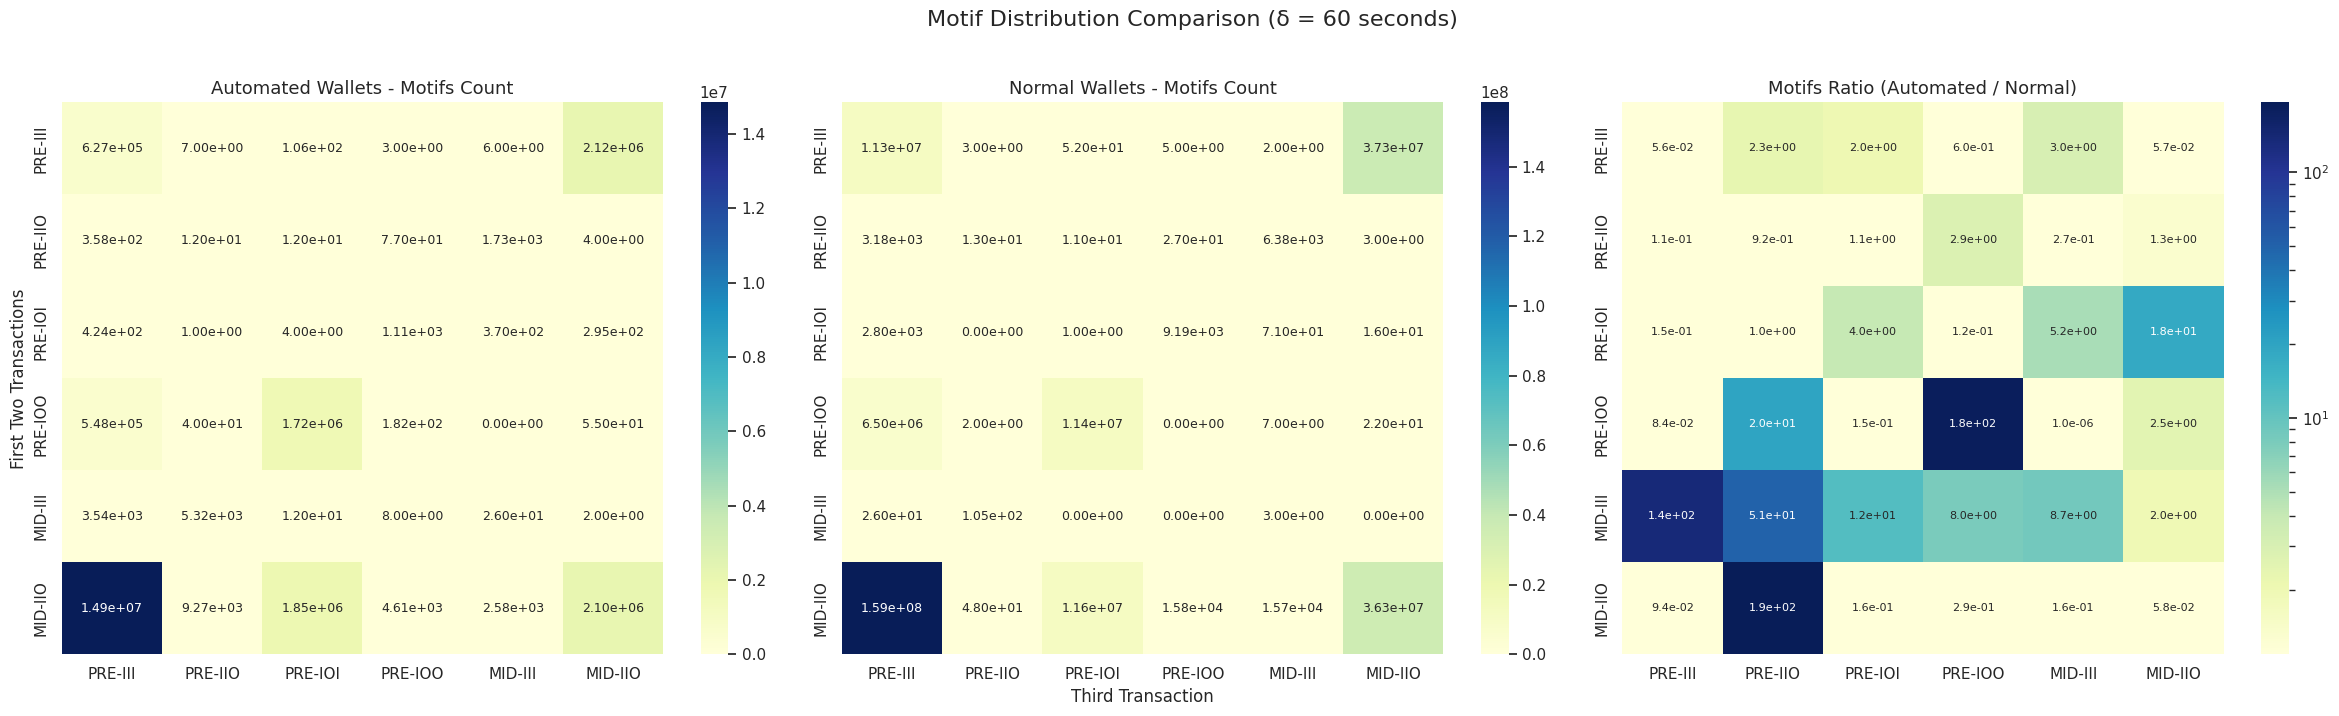

In [ ]:
from matplotlib.colors import LogNorm
from utils.temporal_graph_utils import to_3d_heatmap 


# Map 40 motifs to a 6x6 matrix
motifs_heatmap_automated = to_3d_heatmap(suspicious_motifs)
motifs_heatmap_normal = to_3d_heatmap(normal_motifs)


# Labels
x_labels = ["PRE-III", "PRE-IIO", "PRE-IOI", "PRE-IOO", "MID-III", "MID-IIO"]
y_labels = ["PRE-III", "PRE-IIO", "PRE-IOI", "PRE-IOO", "MID-III", "MID-IIO"]


# Ratio computation (safe division)
motifs_heatmap_normal_safe = np.where(
    motifs_heatmap_normal == 0, 1, motifs_heatmap_normal
)
rate = motifs_heatmap_automated / motifs_heatmap_normal_safe

# Small epsilon for log scale
eps = 1e-6

# Create ONE figure with THREE subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# -------- Plot 1: Automated wallets --------
sns.heatmap(
    motifs_heatmap_automated,
    annot=True,
    fmt=".2e",
    cmap="YlGnBu",
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 9},
    ax=axes[0]
)
axes[0].set_title("Automated Wallets - Motifs Count", fontsize=13)

axes[0].set_ylabel("First Two Transactions")

# -------- Plot 2: Normal wallets --------
sns.heatmap(
    motifs_heatmap_normal,
    annot=True,
    fmt=".2e",
    cmap="YlGnBu",
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 9},
    ax=axes[1]
)
axes[1].set_title("Normal Wallets - Motifs Count", fontsize=13)
axes[1].set_xlabel("Third Transaction")


# -------- Plot 3: Ratio (Log scale) --------
sns.heatmap(
    rate + eps,
    annot=True,
    fmt=".1e",
    cmap="YlGnBu",
    norm=LogNorm(
        vmin=np.min(rate[rate > 1]),
        vmax=np.max(rate)
    ),
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 8},
    ax=axes[2]
)
axes[2].set_title("Motifs Ratio (Automated / Normal)", fontsize=13)

# -------- Global title --------
fig.suptitle(
    "Motif Distribution Comparison (δ = 60 seconds)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.show()


In [ ]:
# Define indices for each motifs category 
categories = {
    "2 nodes, one direction": [24, 25, 26, 27],            # Two-node motifs (first 4)
    "2 nodes, mixed directions": [28, 29, 30, 31],         # Two-node motifs (last 4)
    "3 node star, all incoming": list(range(0, 8)),        # Star-PRE (directions III to OOO)
    "3 node star, all outgoing": list(range(8, 16)),       # Star-MID (directions III to OOO)
    "3 node star, mixed directions": list(range(16, 24)),  # Star-POST (directions III to OOO)
    "Triangles": list(range(32, 40))                        # Triangles (8 motifs)
}

categories_np = {
    cat: np.array(indices, dtype=np.int64)
    for cat, indices in categories.items()
}

# automated wallets
suspicious_set = set(suspicious_wallets.index)

counts_per_category = {cat: [] for cat in categories}
counts_per_category_normal = {cat: [] for cat in categories}


for node_id, counts in tqdm(motifs.items(), total=len(motifs)):

    counts = np.asarray(counts)  # zero-copy if already ndarray

    totals = {
        cat: counts[idx].sum()
        for cat, idx in categories_np.items()
    }

    target = (
        counts_per_category
        if node_id.name in suspicious_set
        else counts_per_category_normal
    )

    for cat, total in totals.items():
        target[cat].append(int(total))


100%|██████████| 7062831/7062831 [01:40<00:00, 70126.14it/s]


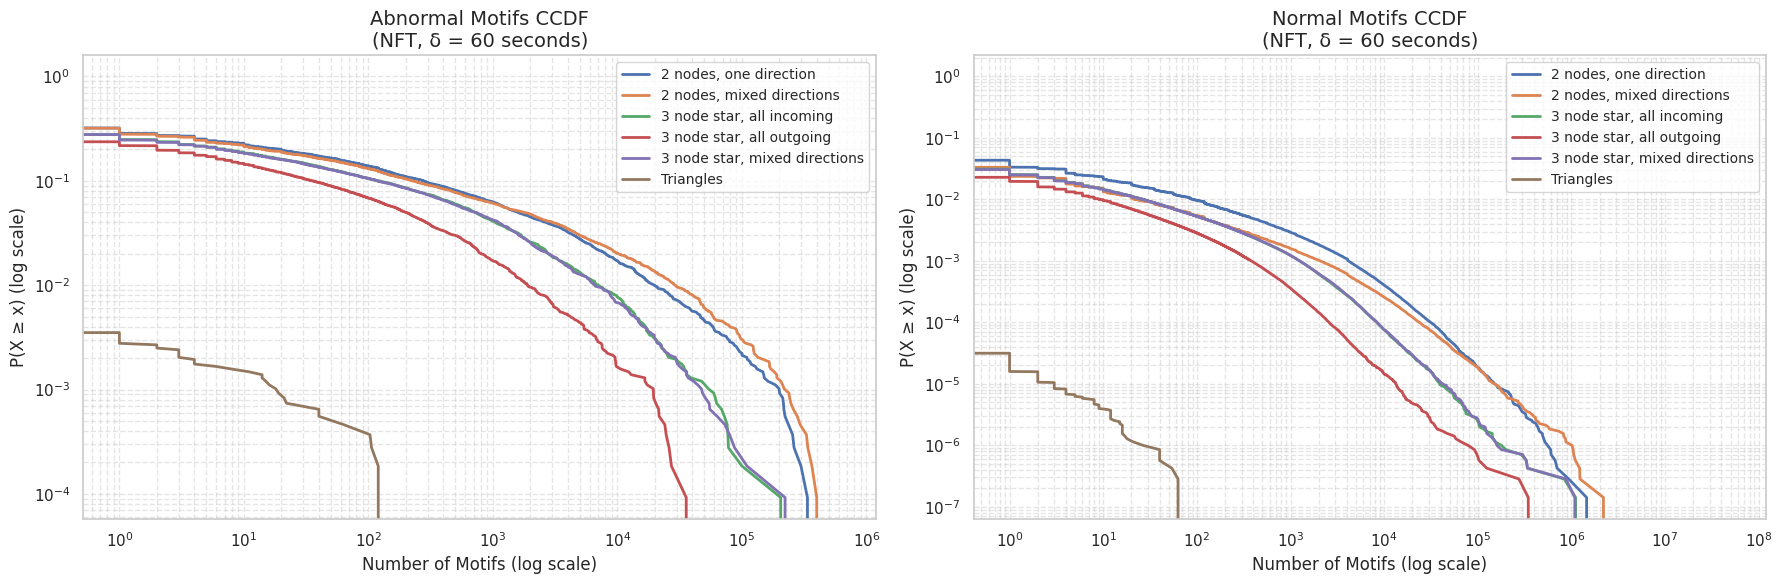

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


# Left plot: Abnormal motifs
ax = axes[0]

for categoria, counts in counts_per_category.items():
    counts = np.array(counts)
    x, y = ccdf(counts)
    if len(x) > 0 and len(y) > 0:
        ax.loglog(x, y, label=categoria, linewidth=2)

ax.set_title("Abnormal Motifs CCDF\n(NFT, δ = 60 seconds)", fontsize=14)
ax.set_xlabel("Number of Motifs (log scale)", fontsize=12)
ax.set_ylabel("P(X ≥ x) (log scale)", fontsize=12)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(fontsize=10, loc="best")


# Right plot: Normal motifs
ax = axes[1]

for categoria, counts in counts_per_category_normal.items():
    counts = np.array(counts)
    x, y = ccdf(counts)
    if len(x) > 0 and len(y) > 0:
        ax.loglog(x, y, label=categoria, linewidth=2)

ax.set_title("Normal Motifs CCDF\n(NFT, δ = 60 seconds)", fontsize=14)
ax.set_xlabel("Number of Motifs (log scale)", fontsize=12)
ax.set_ylabel("P(X ≥ x) (log scale)", fontsize=12)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(fontsize=10, loc="best")


plt.tight_layout()
plt.show()


### Wash Trading

In [ ]:
# suspicious wash traders wallets
suspicious_set = set(suspicious_wash_traders.wallets)


# Temporal Motifs Characterization
suspicious_motifs , normal_motifs , motifs = temporal_motifs_characterization(g,suspicious_wallet=suspicious_set,delta=60*60*24) # delta = 1 day

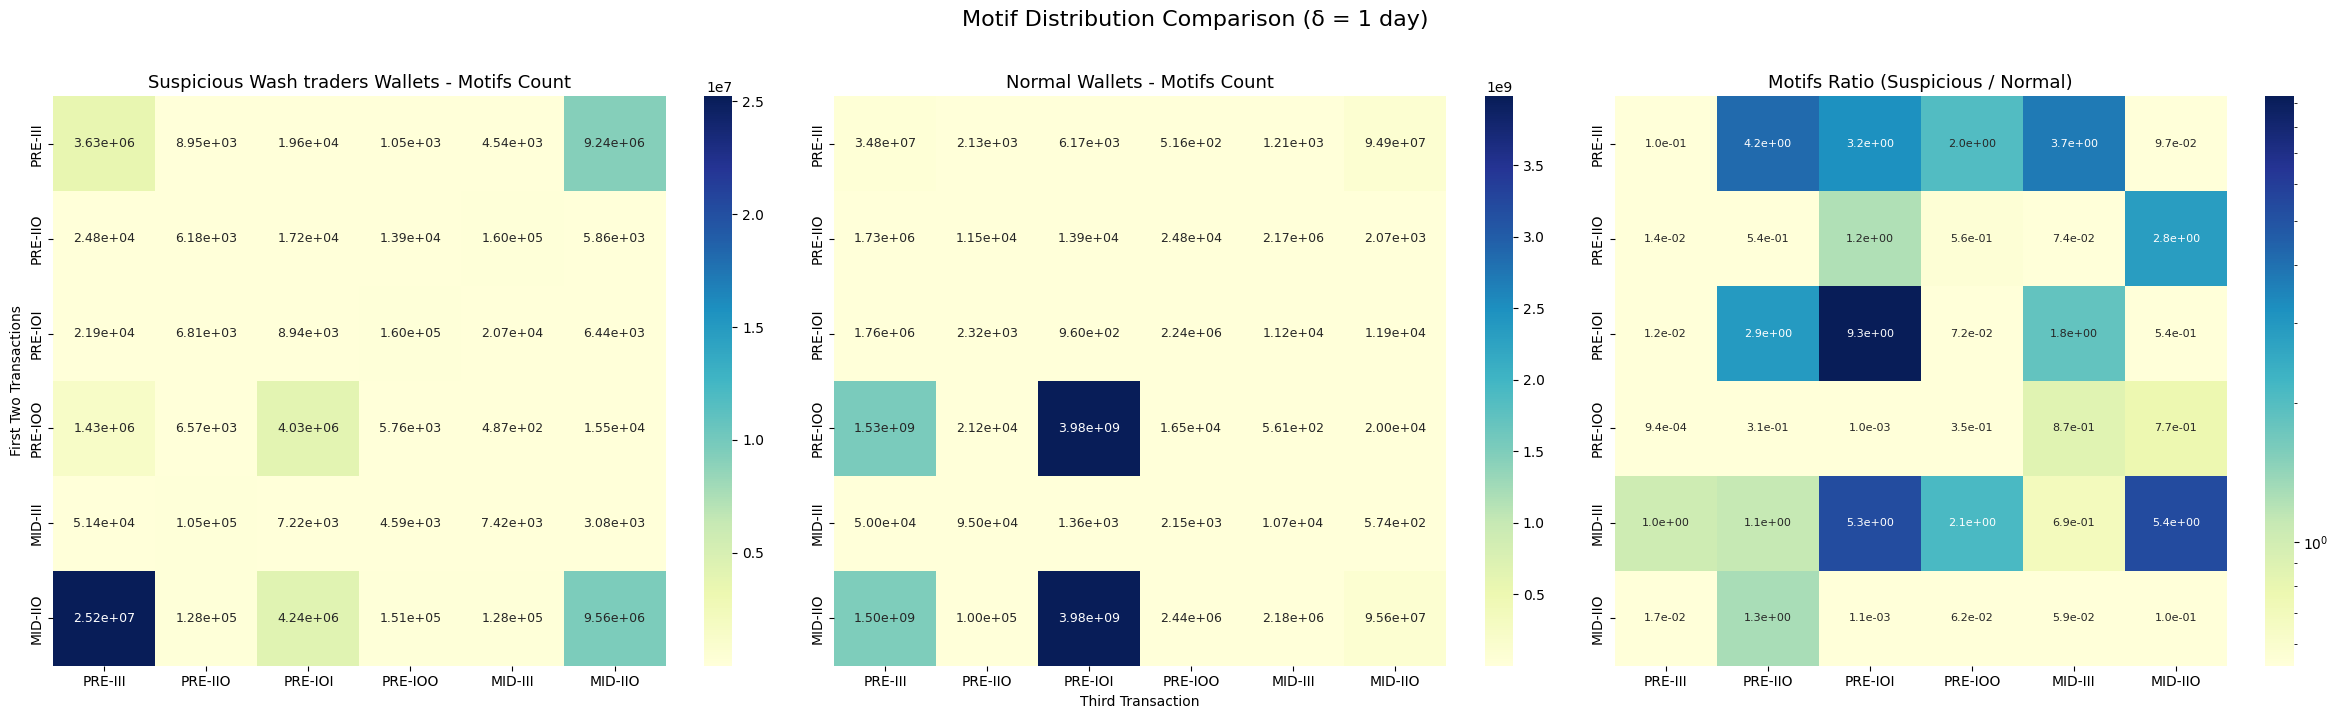

In [39]:
# Map 40 motifs to a 6x6 matrix
motifs_heatmap_automated = to_3d_heatmap(suspicious_motifs)
motifs_heatmap_normal = to_3d_heatmap(normal_motifs)


# Labels
x_labels = ["PRE-III", "PRE-IIO", "PRE-IOI", "PRE-IOO", "MID-III", "MID-IIO"]
y_labels = ["PRE-III", "PRE-IIO", "PRE-IOI", "PRE-IOO", "MID-III", "MID-IIO"]


# Ratio computation (safe division)
motifs_heatmap_normal_safe = np.where(
    motifs_heatmap_normal == 0, 1, motifs_heatmap_normal
)
rate = motifs_heatmap_automated / motifs_heatmap_normal_safe

# Small epsilon for log scale
eps = 1e-6

# Create ONE figure with THREE subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# -------- Plot 1: Automated wallets --------
sns.heatmap(
    motifs_heatmap_automated,
    annot=True,
    fmt=".2e",
    cmap="YlGnBu",
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 9},
    ax=axes[0]
)
axes[0].set_title("Suspicious Wash traders Wallets - Motifs Count", fontsize=13)

axes[0].set_ylabel("First Two Transactions")

# -------- Plot 2: Normal wallets --------
sns.heatmap(
    motifs_heatmap_normal,
    annot=True,
    fmt=".2e",
    cmap="YlGnBu",
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 9},
    ax=axes[1]
)
axes[1].set_title("Normal Wallets - Motifs Count", fontsize=13)
axes[1].set_xlabel("Third Transaction")


# -------- Plot 3: Ratio (Log scale) --------
sns.heatmap(
    rate + eps,
    annot=True,
    fmt=".1e",
    cmap="YlGnBu",
    norm=LogNorm(
        vmin=np.min(rate[rate > 0.4]),
        vmax=np.max(rate)
    ),
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot_kws={"size": 8},
    ax=axes[2]
)
axes[2].set_title("Motifs Ratio (Suspicious / Normal)", fontsize=13)

# -------- Global title --------
fig.suptitle(
    "Motif Distribution Comparison (δ = 1 day)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.show()


In [ ]:
# Define indices for each motifs category 
categories = {
    "2 nodes, one direction": [24, 25, 26, 27],            # Two-node motifs (first 4)
    "2 nodes, mixed directions": [28, 29, 30, 31],         # Two-node motifs (last 4)
    "3 node star, all incoming": list(range(0, 8)),        # Star-PRE (directions III to OOO)
    "3 node star, all outgoing": list(range(8, 16)),       # Star-MID (directions III to OOO)
    "3 node star, mixed directions": list(range(16, 24)),  # Star-POST (directions III to OOO)
    "Triangles": list(range(32, 40))                        # Triangles (8 motifs)
}

categories_np = {
    cat: np.array(indices, dtype=np.int64)
    for cat, indices in categories.items()
}


counts_per_category = {cat: [] for cat in categories}
counts_per_category_normal = {cat: [] for cat in categories}


for node_id, counts in tqdm(motifs.items(), total=len(motifs)):

    counts = np.asarray(counts)  # zero-copy if already ndarray

    totals = {
        cat: counts[idx].sum()
        for cat, idx in categories_np.items()
    }

    target = (
        counts_per_category
        if node_id.name in suspicious_set
        else counts_per_category_normal
    )

    for cat, total in totals.items():
        target[cat].append(int(total))


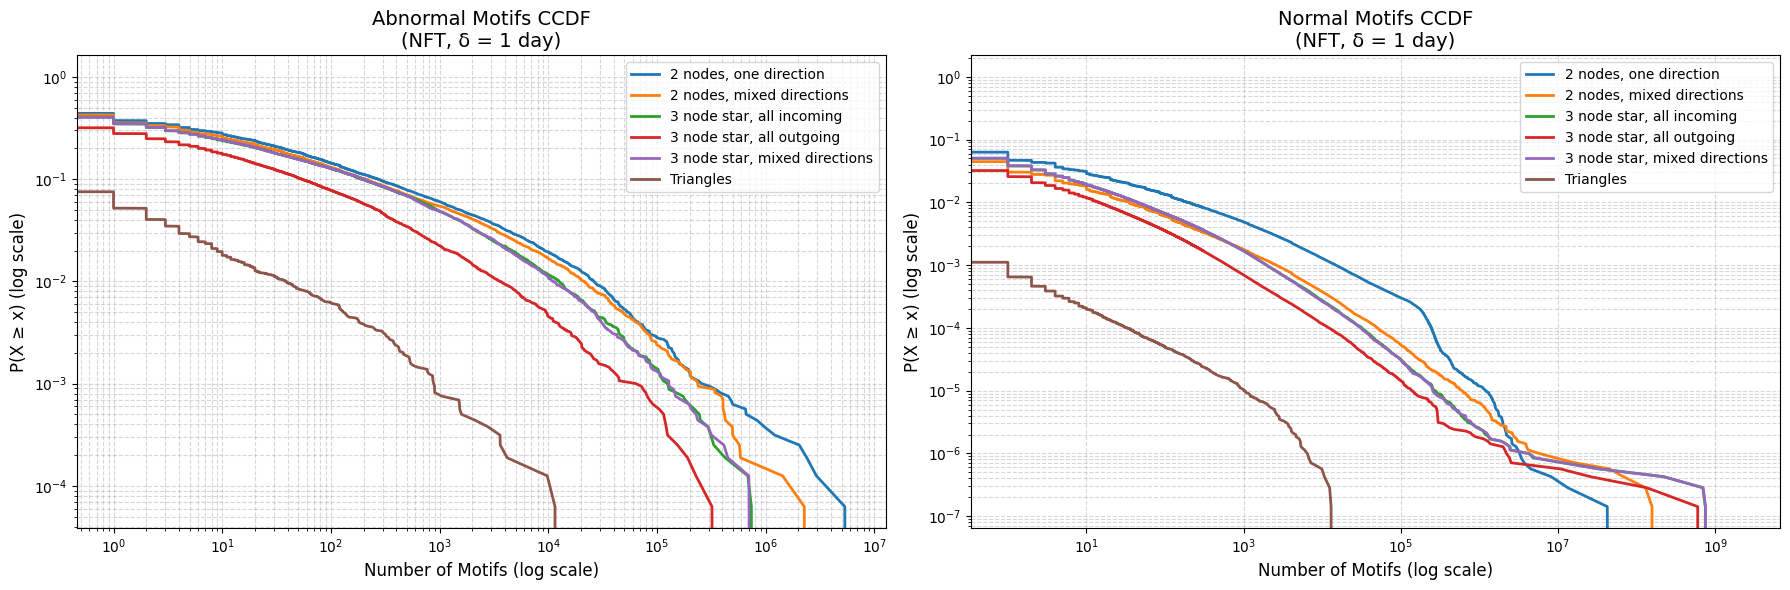

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


# Left plot: Abnormal motifs
ax = axes[0]

for categoria, counts in counts_per_category.items():
    counts = np.array(counts)
    x, y = ccdf(counts)
    if len(x) > 0 and len(y) > 0:
        ax.loglog(x, y, label=categoria, linewidth=2)

ax.set_title("Abnormal Motifs CCDF\n(NFT, δ = 1 day)", fontsize=14)
ax.set_xlabel("Number of Motifs (log scale)", fontsize=12)
ax.set_ylabel("P(X ≥ x) (log scale)", fontsize=12)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(fontsize=10, loc="best")


# Right plot: Normal motifs
ax = axes[1]

for categoria, counts in counts_per_category_normal.items():
    counts = np.array(counts)
    x, y = ccdf(counts)
    if len(x) > 0 and len(y) > 0:
        ax.loglog(x, y, label=categoria, linewidth=2)

ax.set_title("Normal Motifs CCDF\n(NFT, δ = 1 day)", fontsize=14)
ax.set_xlabel("Number of Motifs (log scale)", fontsize=12)
ax.set_ylabel("P(X ≥ x) (log scale)", fontsize=12)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.legend(fontsize=10, loc="best")


plt.tight_layout()
plt.show()

## Case Study (Automated Trading)

In [ ]:
# Improved temporal plot for multiple cycles
def plot_aggregated_temporal_patterns(df, buyer_id, max_cycles=100):
    
    # Filter data for the specific buyer
    buyer_data = df[df['buyer'] == buyer_id].copy()
    
    if buyer_data.empty:
        print(f"No data found for buyer: {buyer_id}")
        return
    
    # Sample cycles if there are too many
    if len(buyer_data) > max_cycles:
        buyer_data = buyer_data.sample(max_cycles, random_state=42)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Convert all timestamps and normalize times
    all_events = []
    for _, row in buyer_data.iterrows():
        cycle_duration = row['duration_days'].total_seconds()
        
        for sale in row['sales']:
            timestamp = pd.to_datetime(sale['time'] / 1000, unit='s')
            norm_time = ((timestamp - row['min_ts']).total_seconds()) / cycle_duration
            
            all_events.append({
                'timestamp': timestamp,
                'norm_time': norm_time,
                'price': sale['price_usd'],
                'cycle_id': row.name
            })
    
    events_df = pd.DataFrame(all_events)
    
    # Temporal density plot (KDE)
    sns.kdeplot(
        data=events_df,
        x='norm_time',
        hue='cycle_id',
        palette='viridis',
        alpha=0.5,
        ax=ax,
        legend=False   # <-- Remove the cycle ID legend
    )
    
    ax.set_title(f'Temporal Transaction Density - Automated Trader')
    ax.set_xlabel('Normalized Cycle Time (0 = Start, 1 = End)')
    ax.set_ylabel('Density')
    
    plt.show()


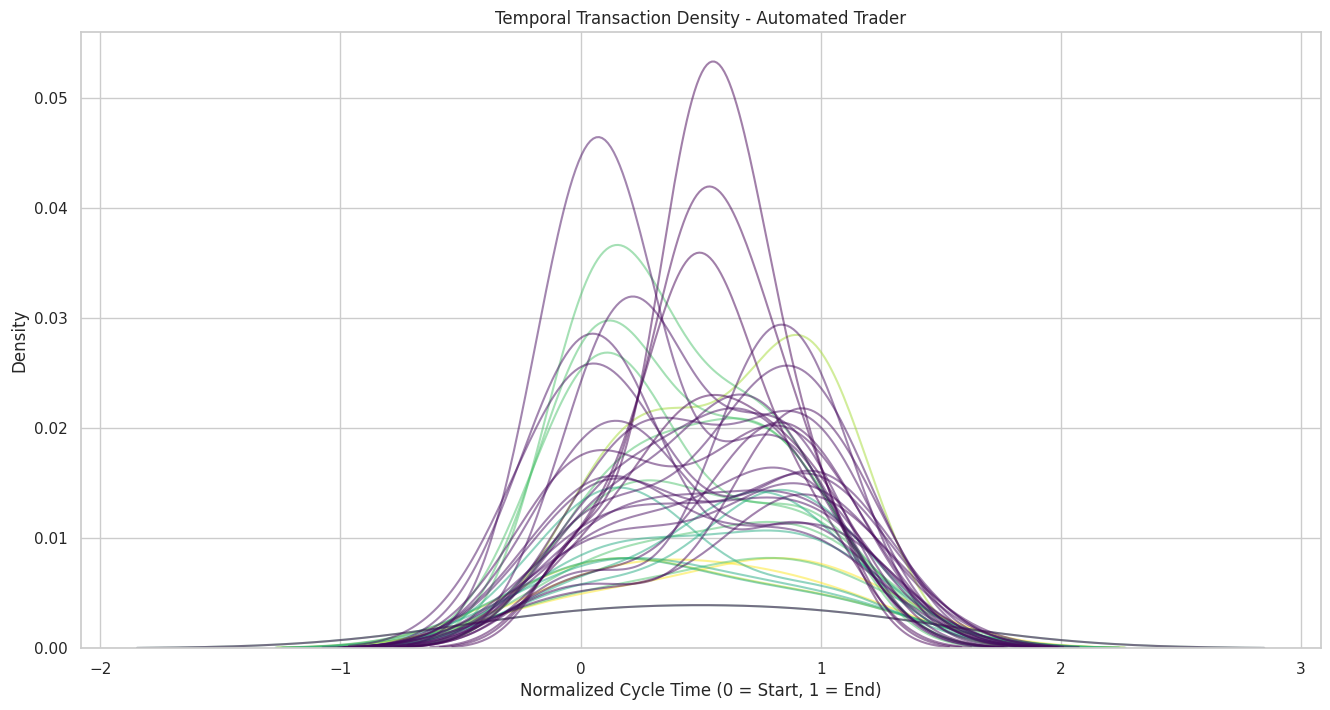

In [ ]:
## Normal Case : w_12277
plot_aggregated_temporal_patterns(df_cycles, "w_12277")


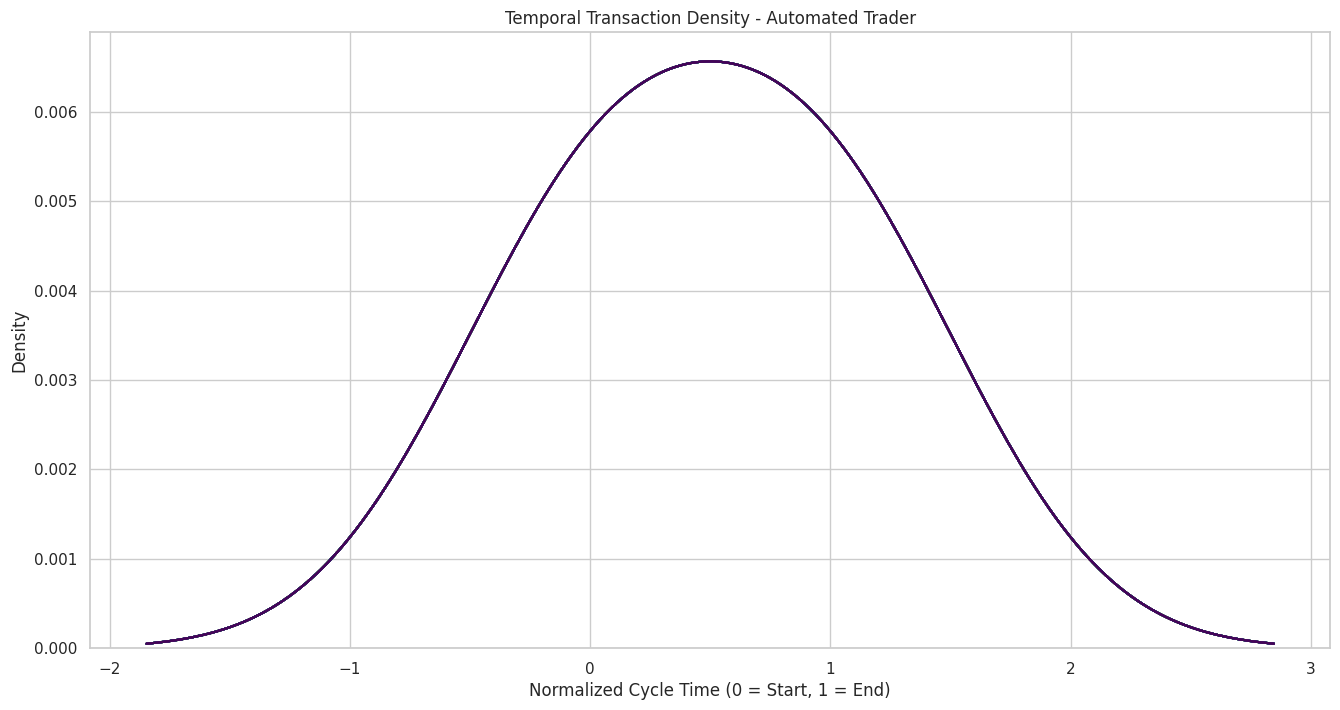

In [ ]:
## Normal Case : w_12277
plot_aggregated_temporal_patterns(df_cycles, "w_1849276")

## Case Study (Wash Trading)

In [ ]:
azuki_9845 = transactions[transactions['nft_num']=='nft_2976387'].sort_values(by="closing_date")[:5]

In [ ]:
azuki_9845

,chain,closing_date,price,currency,seller_num,buyer_num,nft_num,price_usd,collection_name
50719787,ethereum,2022-05-11 01:10:47+00:00,11.0,ETH,w_658436,w_344551,nft_2976387,22916.520,azuki
50662635,ethereum,2022-05-12 00:37:12+00:00,16.0,WETH,w_2616605,w_628768,nft_2976387,30537.120,azuki
50662638,ethereum,2022-05-12 00:37:12+00:00,12.3,ETH,w_344551,w_2616605,nft_2976387,23475.411,azuki
50647904,ethereum,2022-05-12 09:13:06+00:00,11.0,ETH,w_628768,w_344551,nft_2976387,20994.270,azuki
50569591,ethereum,2022-05-13 16:45:55+00:00,16.5,ETH,w_344551,w_843176,nft_2976387,34212.255,azuki


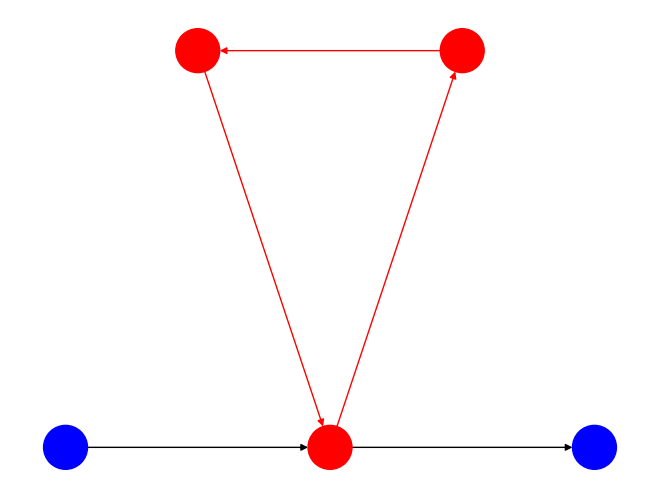

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

g.add_edge('w_658436','w_344551')
g.add_edge('w_2616605', 'w_628768')
g.add_edge('w_344551', 'w_2616605')
g.add_edge('w_628768', 'w_344551')
g.add_edge('w_344551', 'w_843176')

# ---- choose nodes & edges to highlight ----
red_nodes = {'w_344551', 'w_2616605','w_628768'}
red_edges = {('w_344551', 'w_2616605'), ('w_628768', 'w_344551'),('w_2616605', 'w_628768')}

# ---- node colors ----
node_colors = [
    'red' if node in red_nodes else 'blue'
    for node in g.nodes()
]

# ---- edge colors ----
edge_colors = [
    'red' if edge in red_edges else 'black'
    for edge in g.edges()
]

pos = {
    'w_628768': (0.5, 0.5),
    'w_2616605': (1.5, 0.5),
    'w_344551': (1, 0),
    'w_658436': (0, 0),
    'w_843176': (2, 0),
}

nx.draw(
    g,
    pos,
    with_labels=False,
    node_color=node_colors,
    edge_color=edge_colors,
    node_size=1000,
    arrows=True
)

plt.show()
